In [1]:
import os
import cv2
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam, SGD
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

In [2]:
# Convert to tf.data.Dataset
def get_dataset(X, y, batch_size, shuffle=True):
    ds = tf.data.Dataset.from_tensor_slices((X, y))
    if shuffle:
        ds = ds.shuffle(buffer_size=1000)
    ds = ds.batch(batch_size).prefetch(tf.data.AUTOTUNE)
    return ds

In [3]:
IMG_SIZE = 128  # Set image size
data = []
labels = []
dataset_path = "./dataset"

# Load images from dataset
for category in ["with_mask", "without_mask"]:
    folder = os.path.join(dataset_path, category)
    label = 1 if category == "with_mask" else 0  # 1 for mask, 0 for no mask

    for img_name in os.listdir(folder):
        img_path = os.path.join(folder, img_name)
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB
        img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))  # Resize to 128x128
        data.append(img)
        labels.append(label)

# Convert to NumPy arrays and normalize
data = np.array(data) / 255.0
labels = np.array(labels)

print("Dataset loaded successfully!")
print(f"Total samples: {len(labels)}")

# Split into train, validation, test sets
X_train, X_temp, y_train, y_temp = train_test_split(data, labels, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)


# Hyperparameter variations
hyperparams = [
    {'activation': 'sigmoid', 'optimizer': 'adam', 'learning_rate': 0.001, 'batch_size': 32},
    {'activation': 'sigmoid', 'optimizer': 'adam', 'learning_rate': 0.0005, 'batch_size': 64},
    {'activation': 'sigmoid', 'optimizer': 'sgd', 'learning_rate': 0.001, 'batch_size': 32},
    {'activation': 'tanh', 'optimizer': 'adam', 'learning_rate': 0.001, 'batch_size': 32},
]

results = []


libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


Dataset loaded successfully!
Total samples: 4095


In [4]:
# CNN model function
def create_model(activation='sigmoid', optimizer='adam', learning_rate=0.001):
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=(IMG_SIZE, IMG_SIZE, 3)),
        MaxPooling2D((2, 2)),
        
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        
        Conv2D(128, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        
        Flatten(),
        Dense(64, activation='relu'),
        Dropout(0.5),
        Dense(1, activation=activation)
    ])
    
    if optimizer == 'adam':
        opt = Adam(learning_rate=learning_rate)
    elif optimizer == 'sgd':
        opt = SGD(learning_rate=learning_rate, momentum=0.9)
    else:
        opt = Adam(learning_rate=learning_rate)  # fallback
    
    model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])
    return model


In [5]:
for i, params in enumerate(hyperparams):
    print(f"\nTraining model {i+1} with params: {params}")
    
    batch_size = params['batch_size']
    train_ds = get_dataset(X_train, y_train, batch_size)
    val_ds = get_dataset(X_val, y_val, batch_size, shuffle=False)
    
    model = create_model(
        activation=params['activation'],
        optimizer=params['optimizer'],
        learning_rate=params['learning_rate']
    )
    
    history = model.fit(
        train_ds,
        epochs=10,
        validation_data=val_ds,
        verbose=2
    )
    
    # Store history & model for plotting and testing later
    val_acc = history.history['val_accuracy'][-1]
    results.append({'params': params, 'history': history, 'model': model, 'val_acc': val_acc})



Training model 1 with params: {'activation': 'sigmoid', 'optimizer': 'adam', 'learning_rate': 0.001, 'batch_size': 32}


/opt/anaconda3/envs/vr_course/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
90/90 - 30s - 338ms/step - accuracy: 0.8060 - loss: 0.4315 - val_accuracy: 0.8502 - val_loss: 0.3626
Epoch 2/10
90/90 - 38s - 425ms/step - accuracy: 0.8946 - loss: 0.2823 - val_accuracy: 0.8893 - val_loss: 0.2766
Epoch 3/10
90/90 - 32s - 355ms/step - accuracy: 0.9197 - loss: 0.2237 - val_accuracy: 0.8974 - val_loss: 0.2512
Epoch 4/10
90/90 - 27s - 304ms/step - accuracy: 0.9142 - loss: 0.2362 - val_accuracy: 0.9153 - val_loss: 0.2388
Epoch 5/10
90/90 - 26s - 284ms/step - accuracy: 0.9341 - loss: 0.1824 - val_accuracy: 0.9251 - val_loss: 0.2008
Epoch 6/10
90/90 - 24s - 265ms/step - accuracy: 0.9449 - loss: 0.1576 - val_accuracy: 0.9283 - val_loss: 0.1753
Epoch 7/10
90/90 - 24s - 270ms/step - accuracy: 0.9403 - loss: 0.1686 - val_accuracy: 0.9251 - val_loss: 0.2242
Epoch 8/10
90/90 - 23s - 259ms/step - accuracy: 0.9501 - loss: 0.1233 - val_accuracy: 0.9365 - val_loss: 0.1644
Epoch 9/10
90/90 - 24s - 269ms/step - accuracy: 0.9599 - loss: 0.0986 - val_accuracy: 0.9397 - val_loss:

In [6]:
# Plotting function
def plot_metrics(history, params, model_num):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs_range = range(1, len(acc) + 1)
    
    plt.figure(figsize=(12, 5))
    
    # Accuracy Plot
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title(f'Model {model_num}: Accuracy\n{params}')
    
    # Loss Plot
    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title(f'Model {model_num}: Loss\n{params}')
    
    plt.tight_layout()
    plt.show()


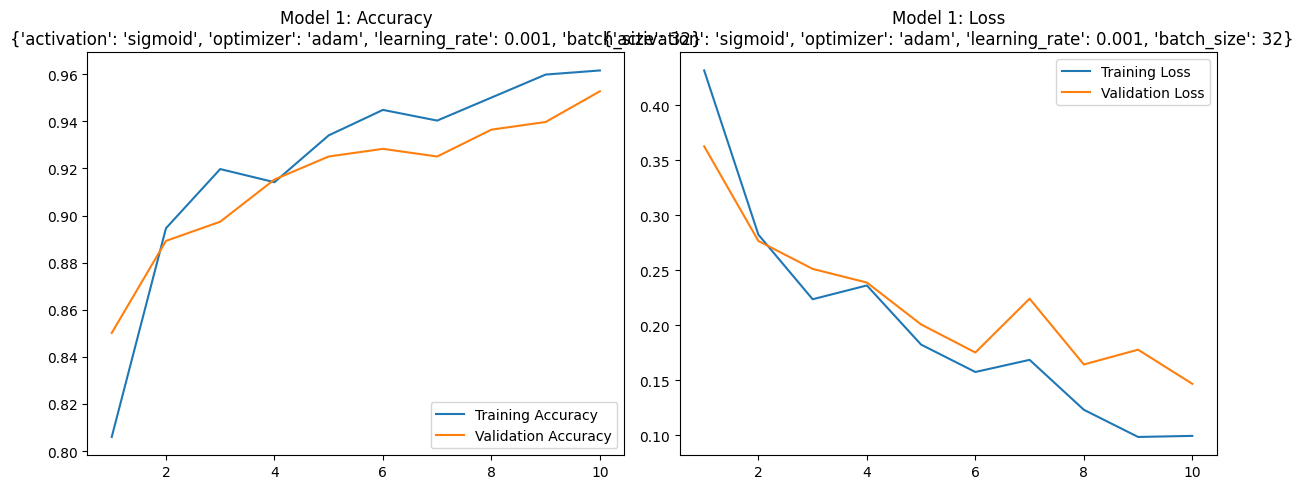

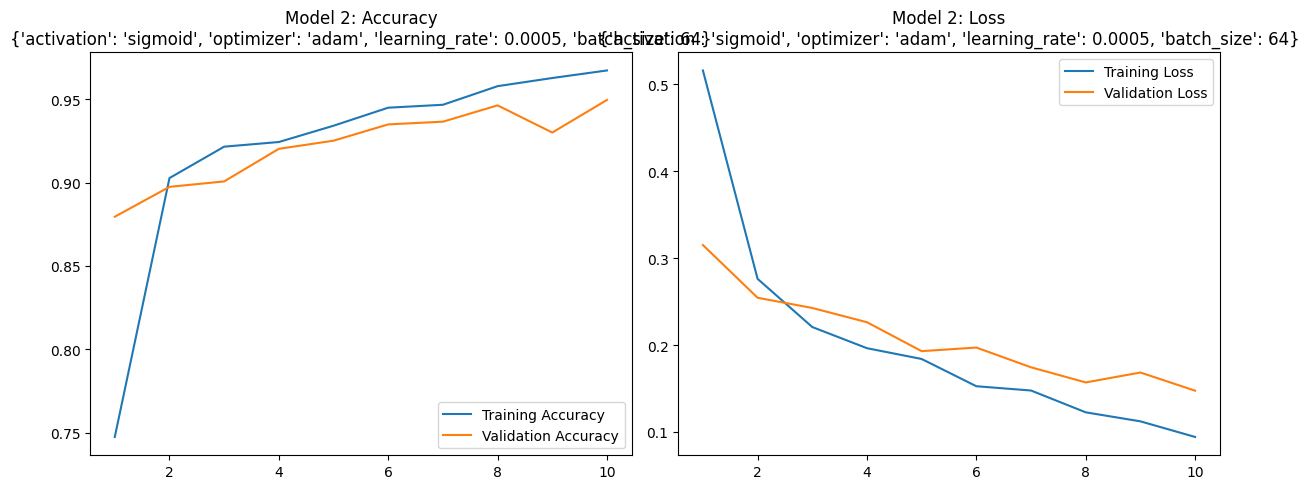

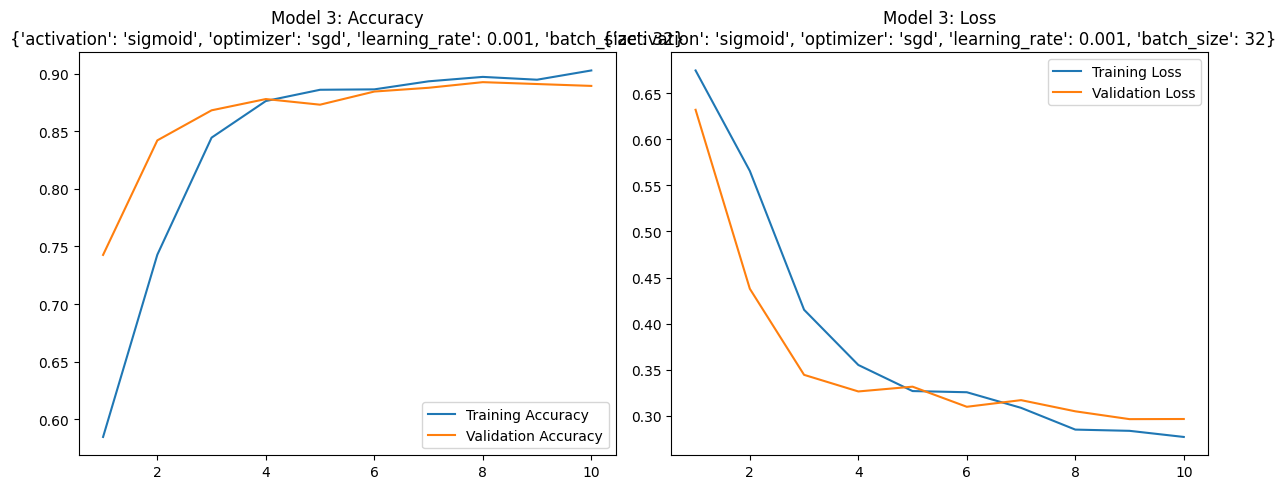

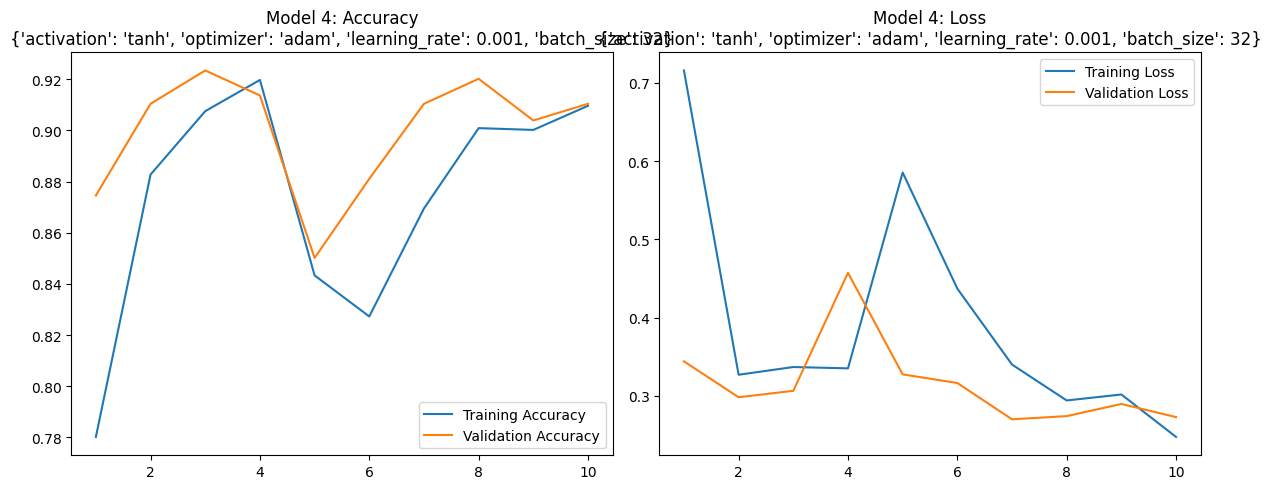


Best Model Params: {'activation': 'sigmoid', 'optimizer': 'adam', 'learning_rate': 0.001, 'batch_size': 32}
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 84ms/step

Classification Report on Test Set:
              precision    recall  f1-score   support

without_mask       0.95      0.96      0.95       275
   with_mask       0.96      0.96      0.96       340

    accuracy                           0.96       615
   macro avg       0.96      0.96      0.96       615
weighted avg       0.96      0.96      0.96       615



In [7]:

# Plot results for each model
for idx, res in enumerate(results):
    plot_metrics(res['history'], res['params'], idx + 1)

# Pick the best model based on validation accuracy
best_model = max(results, key=lambda x: x['val_acc'])
print("\nBest Model Params:", best_model['params'])

# Evaluate on test set
test_ds = get_dataset(X_test, y_test, best_model['params']['batch_size'], shuffle=False)
y_pred_probs = best_model['model'].predict(test_ds)
y_pred = (y_pred_probs.flatten() > 0.5).astype(int)

# Print classification report
print("\nClassification Report on Test Set:")
print(classification_report(y_test, y_pred, target_names=['without_mask', 'with_mask']))

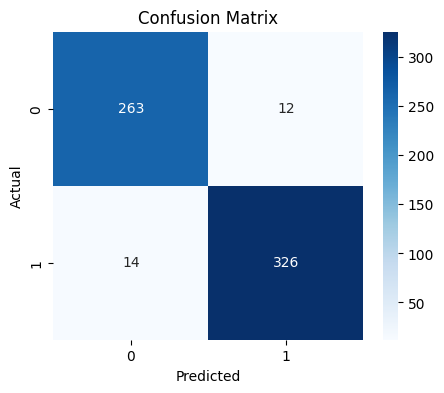

In [8]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title(title)
    plt.show()

plot_confusion_matrix(y_test, y_pred, "Confusion Matrix")